In [44]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF #was tested with NMF but this doesnt give back good results, so the decision was made for LDA

# Methods

This Modelling part is oriented an https://ourcodingclub.github.io/tutorials/topic-modelling-python/

In [24]:
#loading stopword in english, get root words and define which punctuation i wanna get rid of
stopwords_en = nltk.corpus.stopwords.words("english")
root_words = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@…’—	'

#clean the text, input value is a tweet or caption and it returns the cleaned text
def clean_text(text):
    text = text.lower()
    text = re.sub('\s+',' ',text) # remove double spacing
    text = re.sub('[0-9]','',text) #removing numbers
    text = re.sub('(rt\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    text = re.sub('['+my_punctuation + ']+', '', text) # strip punctuation
    token_list = [word for word in text.split(' ') if word not in stopwords_en]
    token_list = [root_words(word) if '#' not in word else word for word in token_list] # apply word rooter
    text = ' '.join(token_list)
    return text

#create a df out of the topics
def create_df(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

#part of the topic modeling, using LatentdirichletAllocation to find the topics, input is an dataframe table and the minimum and maximun for the topics which are to often and to less in the texts
def get_table(df_table,max,min):
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=max, min_df=min, token_pattern='\w+|\$[\d\.]+|\S+')
    #apply transformation
    tf = vectorizer.fit_transform(df_table).toarray()
    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names()
    number_of_topics = 3
    model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
    model.fit(tf)
    return model,tf_feature_names

In [25]:
#Plotting Method
def get_plot(df,title_plot,platform):
    labels_0 = list(df['Topic 0 words'])
    weights_0 = list(df['Topic 0 weights'])
    labels_1 = list(df['Topic 1 words'])
    weights_1 = list(df['Topic 1 weights'])
    labels_2 = list(df['Topic 2 words'])
    weights_2 = list(df['Topic 2 weights'])

    correct_weigths_0 = []
    for i in range(len(weights_0)):
        correct_weigths_0.append(float(weights_0[i]))
    correct_weigths_1 = []
    for i in range(len(weights_0)):
        correct_weigths_1.append(float(weights_1[i])) 
    correct_weigths_2 = []
    for i in range(len(weights_0)):
        correct_weigths_2.append(float(weights_2[i])) 

    if platform == "Twitter":
        fig, ax = plt.subplots(1,3,figsize=(35,3))
        ax[0].barh(labels_0,correct_weigths_0,color="#00A6FF")
        ax[1].barh(labels_1,correct_weigths_1,color='#0061FF')
        ax[2].barh(labels_2,correct_weigths_2,color="#3000f0")
        fig.suptitle(title_plot)
    else:
        fig, ax = plt.subplots(1,3,figsize=(35,3))
        ax[0].barh(labels_0,correct_weigths_0,color='#fa6bec')
        ax[1].barh(labels_1,correct_weigths_1,color="#FF00F7")
        ax[2].barh(labels_2,correct_weigths_2,color='#FF0064')
        fig.suptitle(title_plot)

# Twitter

In [26]:
#connect to database and getting all fetched twitter tweets 
df_twitter = pd.read_sql_query("SELECT user_id,username,tweet_content FROM twitter",con = create_engine('mysql+pymysql://*********@*******/examination_sma'))

In [27]:
#using the textcleaner method to clean all tweets
df_twitter['clean_tweet'] = df_twitter['tweet_content'].apply(lambda x: clean_text(x))

In [28]:
#format the big dataframe into three smaller where i filtered after the username
df_tw_greta = df_twitter[df_twitter['username']=="GretaThunberg"]
df_tw_david = df_twitter[df_twitter['username']=="DavidDobrik"]
df_tw_joe = df_twitter[df_twitter['username']=="JoeBiden"]

In [29]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_tw_greta['clean_tweet'],0.90,0.1)
tm_twitter_greta = create_df(model,tf_feature_names,3)

In [30]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_tw_joe['clean_tweet'],0.90,0.1)
tm_twitter_joe = create_df(model,tf_feature_names,3)

In [31]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_tw_david['clean_tweet'],0.99,0.05)
tm_twitter_david = create_df(model,tf_feature_names,3)

# instagram

In [32]:
#connect to database and getting all fetched twitter tweets 
df_instagram = pd.read_sql_query("SELECT account_id,username,caption FROM instagram",con = create_engine('mysql+pymysql://******@l*****/examination_sma'))

In [33]:
#clean all the captions with the text cleaner method
df_instagram['clean_caption'] = df_instagram['caption'].apply(lambda x: clean_text(x))

In [34]:
#format the big dataframe into three smaller where i filtered after the username
df_insta_greta = df_instagram[df_instagram['username']=="gretathunberg"]
df_insta_david = df_instagram[df_instagram['username']=="daviddobrik"]
df_insta_joe = df_instagram[df_instagram['username']=="joebiden"]

In [35]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_insta_greta['clean_caption'],0.9,0.3)
tm_insta_greta = create_df(model,tf_feature_names,3)

In [36]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_insta_david['clean_caption'],0.99,0.1)
tm_insta_david = create_df(model,tf_feature_names,3)

In [37]:
#executing the topic modeling and getting a dataframe afterwards
model,tf_feature_names = get_table(df_insta_joe['clean_caption'],0.9,0.2)
tm_insta_joe = create_df(model,tf_feature_names,3)

# Plotting

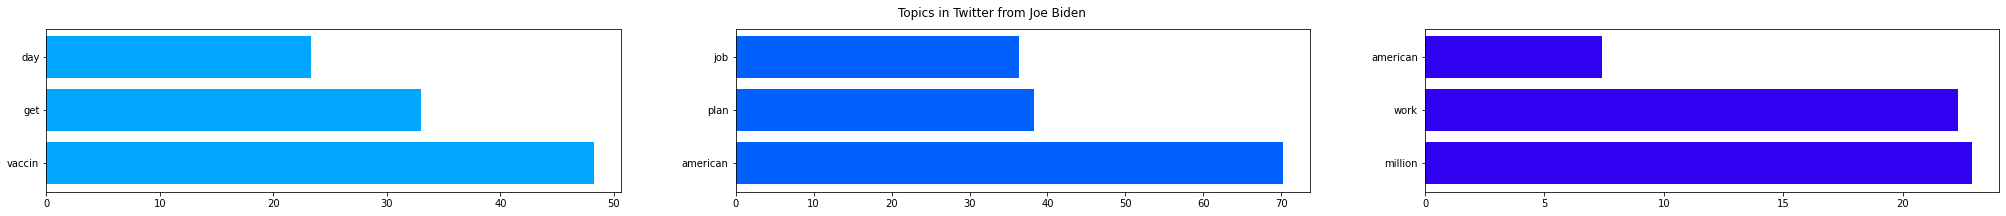

In [38]:
get_plot(tm_twitter_joe,'Topics in Twitter from Joe Biden','Twitter')

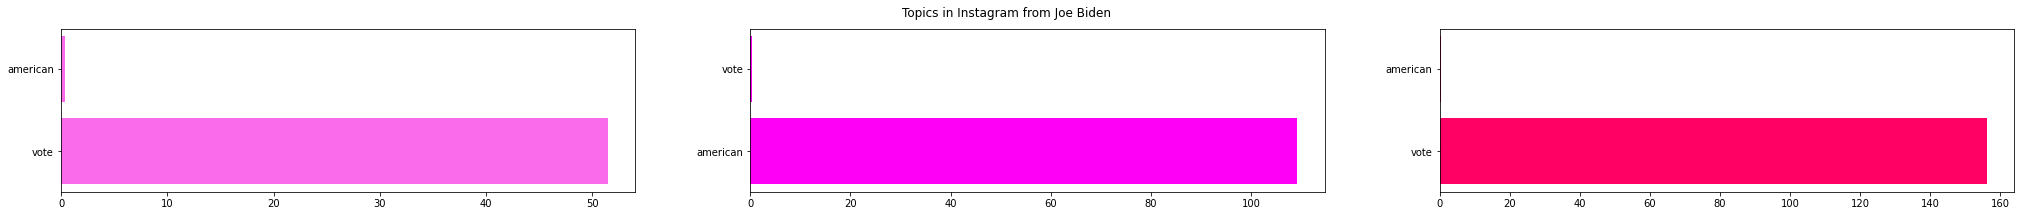

In [39]:
get_plot(tm_insta_joe,'Topics in Instagram from Joe Biden','Instagram')

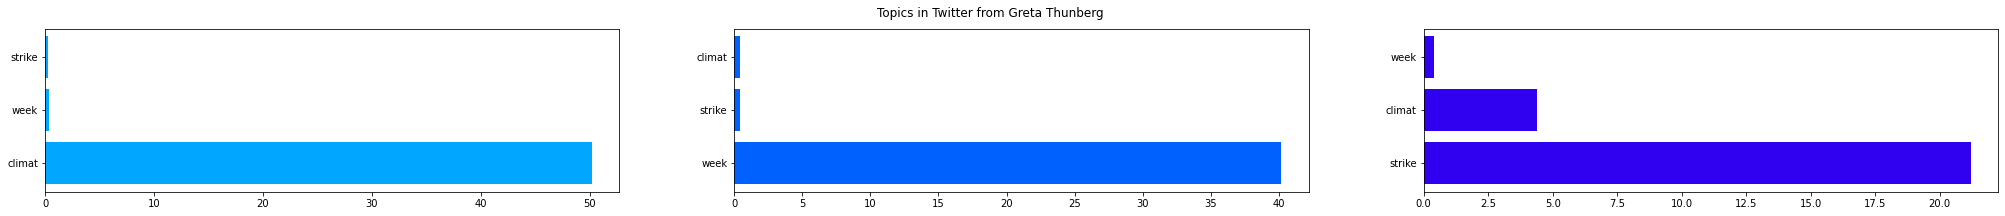

In [40]:
get_plot(tm_twitter_greta,'Topics in Twitter from Greta Thunberg','Twitter')

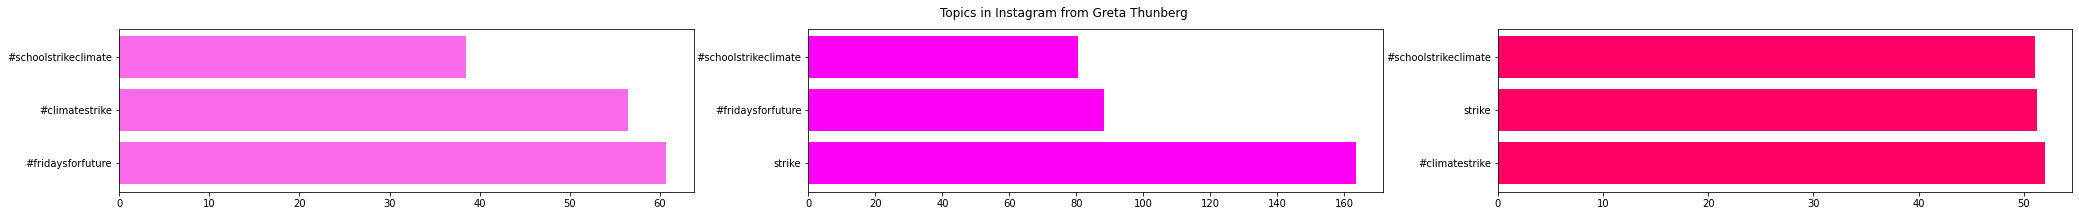

In [41]:
get_plot(tm_insta_greta,'Topics in Instagram from Greta Thunberg','Instagram')

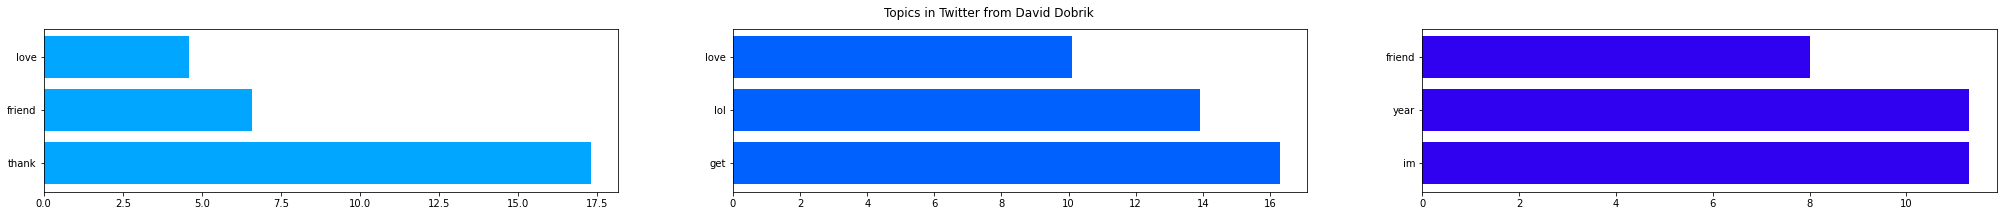

In [42]:
get_plot(tm_twitter_david,'Topics in Twitter from David Dobrik','Twitter')

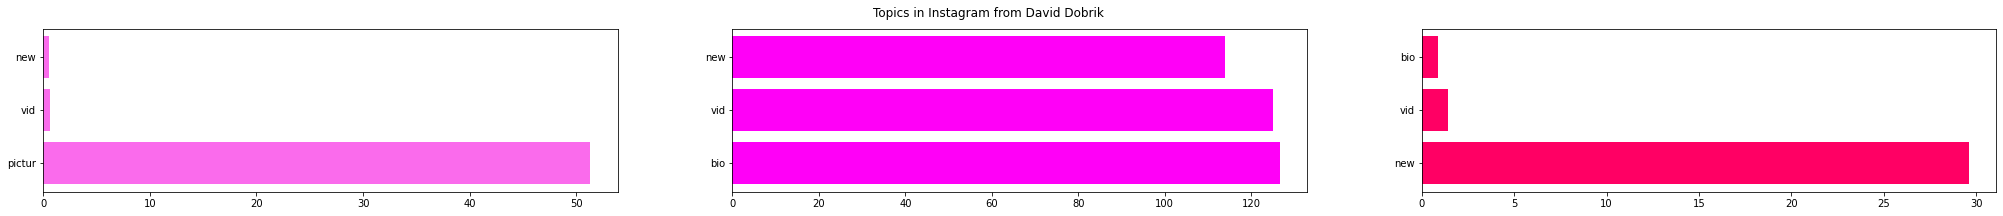

In [43]:
get_plot(tm_insta_david,'Topics in Instagram from David Dobrik','Instagram')